In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import copy
from models.fourier_nn import FourierNet
from floorplans.lidar.lidar import ClippedLidar2D, Lidar2D, RandomPoseLidarDataset, TrajectoryLidarDataset

torch.set_default_tensor_type(torch.DoubleTensor)

In [15]:
data_dir = "../floorplans/32_data"

waypoint_dir = os.path.join(data_dir, "minimal_overlap")
img_path = os.path.join(data_dir, "floor_img.png")

# Data parameters
num_beams = 36
beam_samps = 20
beam_length = 0.2
spline_res = 50
samp_distribution_factor = 1.0
collision_samps = 20
fine_samps = 3

reg_lidar = Lidar2D(img_path, num_beams, beam_length, beam_samps, 
    samp_distribution_factor, collision_samps, fine_samps,
    border_width=5)
clip_lidar = ClippedLidar2D(img_path, num_beams, beam_length, 30,
    border_width=5)

lidar = clip_lidar

datasets = []
for name in glob.glob1(waypoint_dir, "*.npy"):
    waypoints = np.load(os.path.join(waypoint_dir, name))
    ds = TrajectoryLidarDataset(lidar, waypoints, spline_res)
    print()
    print("hd point ratio: ", torch.sum(ds.scans[:,2] == 1.0) / ds.scans.shape[0])
    #ds = RandomPoseLidarDataset(lidar, 6000)
    print("num points: ", len(ds))
    datasets.append(ds)

# Concatenate the entire dataset
cent_ds = torch.utils.data.ConcatDataset(datasets)


hd point ratio:  tensor(0.0284)
num points:  1863923

hd point ratio:  tensor(0.0563)
num points:  1366250

hd point ratio:  tensor(0.0608)
num points:  1038471

hd point ratio:  tensor(0.0546)
num points:  1253272

hd point ratio:  tensor(0.0758)
num points:  976124

hd point ratio:  tensor(0.0386)
num points:  1433924

hd point ratio:  tensor(0.0603)
num points:  1264155


In [5]:
lidar = Lidar2D(img_path, num_beams, beam_length, beam_samps, 
    samp_distribution_factor, collision_samps, fine_samps,
    border_width=30)

num_validation_scans = 500
valset = RandomPoseLidarDataset(lidar, num_validation_scans)
len(valset)

360000

In [6]:
if torch.cuda.is_available(): 
    device = torch.device("cuda")
else: 
    device = torch.device("cpu")

In [7]:
# Setup model and centralized optimizer
model = FourierNet([2, 86, 32, 32, 32, 1], scale=0.05).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005)

epochs = 4
batch_size = 10000

loss = torch.nn.BCELoss()
val_loader = torch.utils.data.DataLoader(valset, batch_size=10000)

for ep in range(epochs):
    train_loader = torch.utils.data.DataLoader(cent_ds,
                batch_size=batch_size, shuffle=True)
    
    tloss = 0.0
    for batch in train_loader:
        opt.zero_grad()
        x, y = batch[0].to(device), batch[1].to(device)
        pd = model.forward(x).squeeze()
        l = loss(pd, y)
        l.backward()
        tloss += l.data
        opt.step()
    
    print("-------------------------------")
    print("Epoch: ", ep)
    print("Train loss: ", tloss / len(train_loader))
    
    with torch.no_grad():
        vloss = 0.0
        for batch in val_loader:
            x, y = batch[0].to(device), batch[1].to(device)
            pd = model.forward(x).squeeze()
            vloss += loss(pd, y).data
    print("Valid loss: ", vloss)

-------------------------------
Epoch:  0
Train loss:  tensor(0.1371, device='cuda:0')
Valid loss:  tensor(3.3343, device='cuda:0')
-------------------------------
Epoch:  1
Train loss:  tensor(0.0683, device='cuda:0')
Valid loss:  tensor(3.5639, device='cuda:0')
-------------------------------
Epoch:  2
Train loss:  tensor(0.0605, device='cuda:0')
Valid loss:  tensor(3.1595, device='cuda:0')
-------------------------------
Epoch:  3
Train loss:  tensor(0.0574, device='cuda:0')
Valid loss:  tensor(3.1349, device='cuda:0')


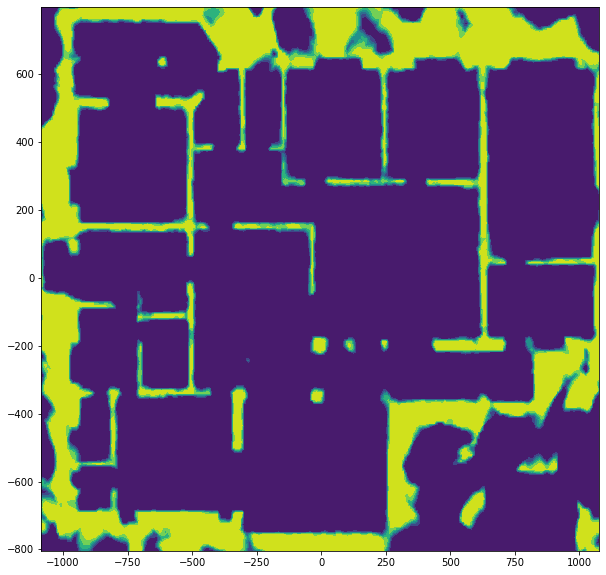

In [8]:
X, Y = torch.meshgrid(torch.Tensor(lidar.xs), torch.Tensor(lidar.ys))
xlocs = X[::8, ::8].reshape(-1, 1)
ylocs = Y[::8, ::8].reshape(-1, 1)
mesh_inputs = torch.hstack((xlocs, ylocs))
mesh_inputs = mesh_inputs.to(device)

with torch.no_grad():
    mesh_dense = model.forward(mesh_inputs)

(fig, ax) = plt.subplots(figsize=(10, 10))
ax.tricontourf(xlocs.squeeze(), ylocs.squeeze(), mesh_dense.squeeze().cpu())